In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import *
from iminuit import Minuit, describe, Struct

# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw

# Siddharth and Laura's Stuff
from NPTFit import create_mask as cm
import constants_noh as constants
import units

In [2]:
trials = 5
channel = 'b'
Nb = 1
conc = ["SP", "S"]
xsecs = np.logspace(-27, -23, 20)
marr = [ 40 ]
colors = [ "blue", "green", "red", "cyan", "magenta", "gold"]
ebins = [1,100]

In [3]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('fermi_data/fermidata_exposure.npy'))
mask = cm.make_mask_total(band_mask = True, band_mask_range = 10, mask_ring = False)
area_rat = (len(mask[~mask]))/len(mask)

In [4]:
# Defining some constants
Fcons = 6.2415e2*1.35e-12 # energy flux
myFcons = 7.742636826811278e-09 # count flux
Fopt = 6.2415e2*4e-13 # energy flux
r_s = 199 # scale radius, [kpc]
alpha = 0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e12 # [M_s]
mMin_calib = 1e8 # [M_s]
mMax_calib = 1e10 # [M_s]
mMin = 1e6 #1e-8*M_MW
mMax = 1e9 # [M_s]
min_flux =np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask])))

In [5]:
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)

N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos
N_subs = 2*np.random.poisson(N_subs)
print(N_subs)
#N_subs = 40000

def mCDFInv(r):
    return ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*r )**(-1/.9)

rho_s2 = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, constants.r_vir)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

38502


In [6]:
r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_Ein(r), r_arr, nsamples=N_subs)
m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 80000) # mass values to test
m_sampler = InverseTransform.InverseTransform(dNdm_func, m_arr, nsamples=N_subs)

In [7]:
PS_arr = []
flux_bins = np.logspace(-15, -6, 8*8)
for im, DMmass in enumerate(marr):
    num_marr1 = []
    num_marr2 = []
    for xsec in tqdm_notebook(xsecs):
        num_xsec1 = 0
        num_xsec2 = 0
        for i in range(trials):
            rval_arr = r_sampler.sample()
            mval_arr = m_sampler.sample()

            theta_arr = (np.arccos(2*np.random.rand(N_subs)-1))
            phi_arr = (2*np.pi*np.random.rand(N_subs))

            mval_arr = mval_arr[rval_arr < 400*units.kpc]
            theta_arr = theta_arr[mval_arr < 400*units.kpc]
            phi_arr = phi_arr[mval_arr < 400*units.kpc]
            rval_arr = rval_arr[rval_arr < 400*units.kpc]

            PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
            PS_set.calcJ(conc[0])
            J1 = PS_set.J.value
            PS_set.calcJ(conc[1])
            J2 = PS_set.J.value
            PS_arr.append(PS_set)

            if i == 0: PPnoxsec = PS_set.PPnoxsec(DMmass, ebins, channel, energy=True)
            flux1 = J1[~mask[PS_set.pixels]] * xsec * PPnoxsec
            flux2 = J2[~mask[PS_set.pixels]] * xsec * PPnoxsec
            num_xsec1 += len(flux1[flux1 > Fcons])
            num_xsec2 += len(flux2[flux2 > Fcons])
        num_marr1.append(num_xsec1/trials)
        num_marr2.append(num_xsec2/trials)
    #np.save("marr"+str(DMmass), num_marr)

[20.10891315 19.63359323 16.65509788 ... 19.36509364 20.14473519
 19.86047252]
[2.26886525e+51 3.38521603e+51 4.52325122e+52 ... 4.25075289e+51
 2.20179944e+51 2.79535478e+51]
[20.10891315 19.63359323 16.65509788 ... 19.36509364 20.14473519
 19.86047252]
[18.87507959 17.43146718 15.08978877 ... 20.08476911 14.18895285
 17.00388036]
[1.98316300e+51 2.63376720e+51 3.69064543e+52 ... 4.59416192e+51
 1.06169561e+51 2.01504308e+51]
[18.87507959 17.43146718 15.08978877 ... 20.08476911 14.18895285
 17.00388036]


/group/hepheno/heptools/anaconda3/envs/venv_py35/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


[18.18678537 18.36306525 19.71180319 ... 20.15487713 20.27112965
 19.90964106]
[1.17085439e+52 1.00470503e+52 3.16870199e+51 ... 2.18318284e+51
 1.98094734e+51 2.68204277e+51]
[18.18678537 18.36306525 19.71180319 ... 20.15487713 20.27112965
 19.90964106]
[16.8472931  20.85306334 23.41219006 ... 11.8226653  15.32832851
 26.67166879]
[9.97619758e+51 1.31669642e+52 4.58974961e+51 ... 7.31255897e+50
 1.10312004e+51 5.06263181e+51]
[16.8472931  20.85306334 23.41219006 ... 11.8226653  15.32832851
 26.67166879]
[20.27385654 19.84043068 18.98262368 ... 19.61349922 19.54918616
 19.10325102]
[1.97644084e+51 2.84293711e+51 5.89126279e+51 ... 3.44324928e+51
 3.63592611e+51 5.31362716e+51]
[20.27385654 19.84043068 18.98262368 ... 19.61349922 19.54918616
 19.10325102]
[18.33679423 17.92997782 20.25940455 ... 13.36718946 22.68168607
 23.24685623]
[1.59706097e+51 2.29474475e+51 6.76630464e+51 ... 1.55869898e+51
 5.00333237e+51 8.10085538e+51]
[18.33679423 17.92997782 20.25940455 ... 13.36718946 22.681

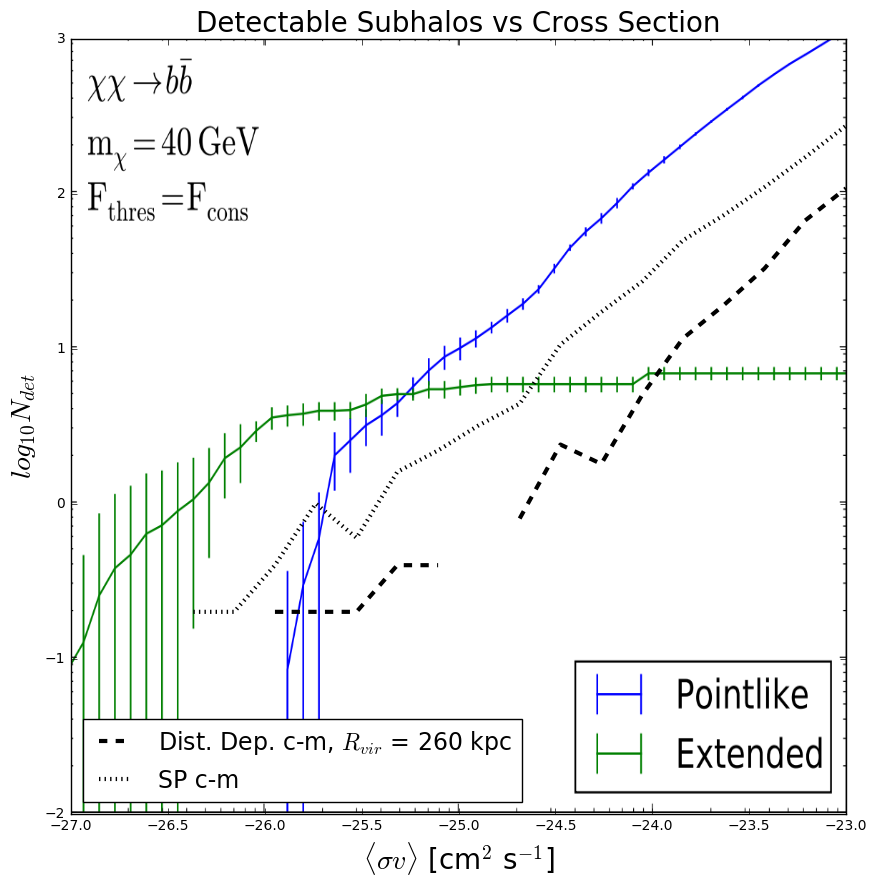

In [8]:
plt.figure(figsize=(10,10))
img = plt.imread("../1601067814.png")
plt.imshow(img, extent=[-27,-23, -2,3], aspect='auto')
#num = []
#for im in range(len(marr)):
#    num.append(np.load("marr"+str(marr[im])+".npy"))
for im, DMmass in enumerate(marr):
    plt.plot(np.log10(xsecs), np.log10(np.array(num_marr1)), c="black", linestyle='--', linewidth=3, label="Dist. Dep. c-m, $R_{vir}$ = 260 kpc")
    plt.plot(np.log10(xsecs), np.log10(np.array(num_marr2)), c="black", linestyle=':', linewidth=3, label="SP c-m")
#plt.plot(np.log10(xsecs/np.pi), np.log10(np.array(num_marr)), c="black", linestyle=':', linewidth=3, label="Scaled up by 2")
#plt.xscale("log")
#plt.yscale("log")
plt.ylim(-2,3)
plt.xlim(-27, -23 )
plt.xlabel("$\\langle \\sigma v \\rangle$ [cm$^2$ s$^{-1}$]", fontsize=20)
plt.ylabel("$log_{10}N_{det}$", fontsize=20)
plt.legend(fontsize=17, loc=3)
plt.title("Detectable Subhalos vs Cross Section", fontsize=20)

In [9]:
PS_arr = []
num = []
flux_bins = np.logspace(-15, -6, 8*8)
DMmass = 40
xsec = 3e-25
trials = 100
mval_tot1 = np.zeros(7)
mval_tot2 = np.zeros(7)
for trial in tqdm_notebook(range(trials)):
    rval_arr = r_sampler.sample()
    mval_arr = m_sampler.sample()

    theta_arr = (np.arccos(2*np.random.rand(N_subs)-1))
    phi_arr = (2*np.pi*np.random.rand(N_subs))

    mval_arr = mval_arr[rval_arr < 400*units.kpc]
    theta_arr = theta_arr[mval_arr < 400*units.kpc]
    phi_arr = phi_arr[mval_arr < 400*units.kpc]
    rval_arr = rval_arr[rval_arr < 400*units.kpc]

    PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
    PS_set.calcJ(conc[0])
    J1 = PS_set.J.value
    PS_set.calcJ(conc[1])
    J2 = PS_set.J.value
    PS_arr.append(PS_set)

    PPnoxsec = PS_set.PPnoxsec(DMmass, ebins, channel, energy=True)
    flux1 = J1[~mask[PS_set.pixels]] * xsec * PPnoxsec
    flux2 = J2[~mask[PS_set.pixels]] * xsec * PPnoxsec
    mval_arr1 = mval_arr[~mask[PS_set.pixels]][flux1 > Fcons]
    mval_arr2 = mval_arr[~mask[PS_set.pixels]][flux2 > Fcons]
    bins1 = np.histogram(mval_arr1, bins=np.logspace(5,11,8))
    bins2 = np.histogram(mval_arr2, bins=np.logspace(5,11,8))
    mval_tot1 += np.array(bins1[0])/trials
    mval_tot2 += np.array(bins2[0])/trials

[18.45908244 20.07056645 19.70356623 ... 18.98108688 20.23851228
 20.20326619]
[9.24549487e+51 2.34297817e+51 3.19082142e+51 ... 5.89902239e+51
 2.03567367e+51 2.09655281e+51]
[18.45908244 20.07056645 19.70356623 ... 18.98108688 20.23851228
 20.20326619]
[18.1572059  21.09431728 20.86271533 ... 17.07534287 20.17143016
 22.7738115 ]
[8.92983145e+51 2.60637112e+51 3.60545634e+51 ... 4.72290690e+51
 2.02128702e+51 2.71335018e+51]
[18.1572059  21.09431728 20.86271533 ... 17.07534287 20.17143016
 22.7738115 ]


/group/hepheno/heptools/anaconda3/envs/venv_py35/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


[19.14143406 19.75166799 18.6027666  ... 19.96603927 18.13201827
 20.1598554 ]
[5.14311740e+51 3.06384571e+51 8.16618973e+51 ... 2.55783981e+51
 1.22799788e+52 2.17410371e+51]
[19.14143406 19.75166799 18.6027666  ... 19.96603927 18.13201827
 20.1598554 ]
[15.89306396 17.31737265 15.38597194 ... 22.65627224 13.93510202
 19.03511444]
[3.48574695e+51 2.32141398e+51 5.49992518e+51 ... 3.35696969e+51
 7.13643763e+51 1.92418741e+51]
[15.89306396 17.31737265 15.38597194 ... 22.65627224 13.93510202
 19.03511444]
[19.62940645 19.56611979 18.32868481 ... 20.24005411 15.90044727
 20.10855087]
[3.39722474e+51 3.58414878e+51 1.03510361e+52 ... 2.03305223e+51
 8.93246623e+52 2.26955408e+51]
[19.62940645 19.56611979 18.32868481 ... 20.24005411 15.90044727
 20.10855087]
[19.41757141 15.85052422 14.02494546 ... 18.70562888 14.30532993
 18.55502671]
[3.31975036e+51 2.30578129e+51 5.95713176e+51 ... 1.71943874e+51
 7.19619649e+52 1.91341767e+51]
[19.41757141 15.85052422 14.02494546 ... 18.70562888 14.305

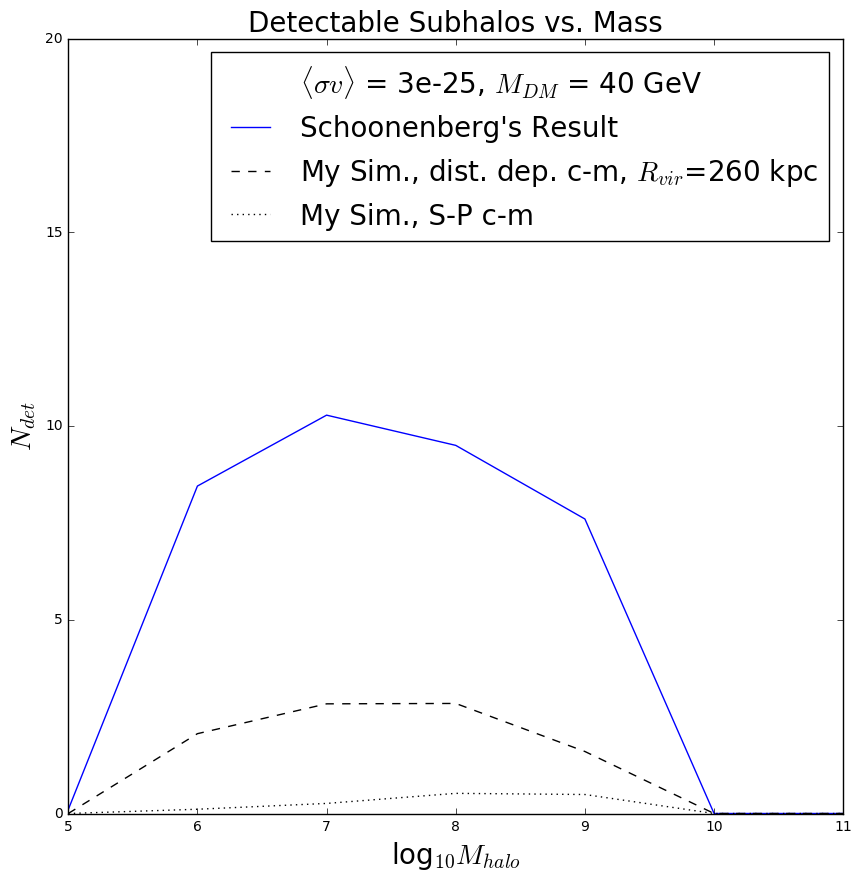

In [12]:
plt.figure(figsize=(10,10))
#img = plt.imread("../1601067812.png")
#plt.imshow(img, extent=[5,11,0,20], aspect='auto')

#plt.plot(np.linspace(5, 11, 7), [0.1, 8.2, 10.1, 8.2, 3.4, 0, 0])
#plt.plot(np.linspace(5, 11, 7), [0, .25, .18, 1.3, 4.2, 0, 0])
plt.plot([0],[0], label="$\\langle \\sigma v \\rangle$ = 3e-25, $M_{DM}$ = 40 GeV", color="white")
plt.plot(np.linspace(5, 11, 7), np.array([0.1, 8.45, 10.28, 9.5, 7.6, 0, 0]), label="Schoonenberg's Result")
plt.plot(np.linspace(5, 11, 7), mval_tot2, c="black", linestyle="--", label="My Sim., dist. dep. c-m, $R_{vir}$=260 kpc")
plt.plot(np.linspace(5, 11, 7), mval_tot1, c="black", linestyle=":", label="My Sim., S-P c-m")
plt.ylim(0,20)
plt.xlim(5, 11)
plt.ylabel("$N_{det}$", fontsize=20)
plt.xlabel("log$_{10}M_{halo}$", fontsize=20)
plt.title("Detectable Subhalos vs. Mass", fontsize=20)
plt.legend(fontsize=20)